## 03.SARIMA

- Realizado por: 
  Francisco del Val Yague, Alejandro García Girón y Laura Martínez González de Aledo

- Emails: 
  *francisco.delval@cunef.edu, a.garciagiron@cunef.edu y l.martinezg@cunef.edu*
  
Colegio Universitario de Estudios Financieros. CUNEF

In [1]:
# LIBRERIAS

# Manipulacion del DataFrame
import pandas as pd
import numpy as np

# Series Temporales
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import itertools

# Metricas
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Graficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sbn

# Warnings
import warnings;
warnings.filterwarnings('ignore')

# Sin puntos suspensivos
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [2]:
consumo_energia = pd.read_csv("../data/02_intermediate/demanda_energia_total.csv")

In [3]:
consumo_energia.head()

,time,demanda_energia
0,2016-01-01,515581.473
1,2016-01-02,578184.270
2,2016-01-03,584378.725
3,2016-01-04,666565.106
4,2016-01-05,663020.147


In [4]:
consumo_energia.tail()

,time,demanda_energia
1819,2020-12-24,608801.8
1820,2020-12-25,540441.9
1821,2020-12-26,605654.0
1822,2020-12-27,611892.0
1823,2020-12-28,670801.3


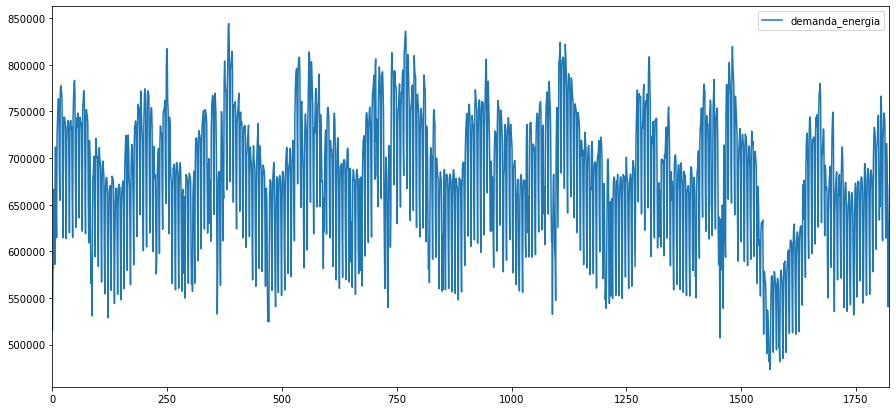

In [5]:
consumo_energia.plot(figsize=(15,7))
plt.show()

### Modelo Sarima

*SARIMA (p,d,q) (P,D,Q,m):*

Es muy parecido a ARIMA, pero un poco más complicado. No solo debe usar una búsqueda de bucle y cuadrícula para los valores óptimos de p, d y q, sino que también debe usar una búsqueda de bucle y cuadrícula anidados para los valores estacionales de p, d y q. También hay muchos más parámetros en la función SARIMAX.

In [6]:
dates = pd.date_range(start='2016-01-01', freq='MS', periods=len(consumo_energia))
dates[0:60]

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
      

In [7]:
consumo_energia.set_index(dates,inplace=True)
consumo_energia.drop('time',axis=1,inplace=True)

In [8]:
train = (consumo_energia[consumo_energia.index < '2018-06-01'])
test = (consumo_energia[consumo_energia.index >= '2018-06-01'])

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [10]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [13]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best SARIMAX {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

Best SARIMAX (0, 1, 1) x (0, 1, 1, 12) model - AIC:55.56686626778753


### Ajustamos el modelo:

In [15]:
# using the best parameter in the model
model = SARIMAX(train,order=(0,1,1),seasonal_order=(0, 1, 1, 12),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

In [21]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    demanda_energia   No. Observations:                   29
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -24.783
Date:                            Fri, 15 Jan 2021   AIC                             55.567
Time:                                    12:53:40   BIC                             51.646
Sample:                                01-01-2016   HQIC                            47.368
                                     - 05-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1696   5240.666   3.24e-05      1.000   -1.03e+04    1.03e+04
ma.S.L12      -0.8545   1829.137     -0.000      1.000   -3585.898    3584.189
sigma2      9.227e+09      0.002   4.31e+12      0.000    9.23e+09    9.23e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.16   Prob(JB):                         0.85
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         1.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+28. Standard errors may be unstable.
"""

### Prediccion:

In [16]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

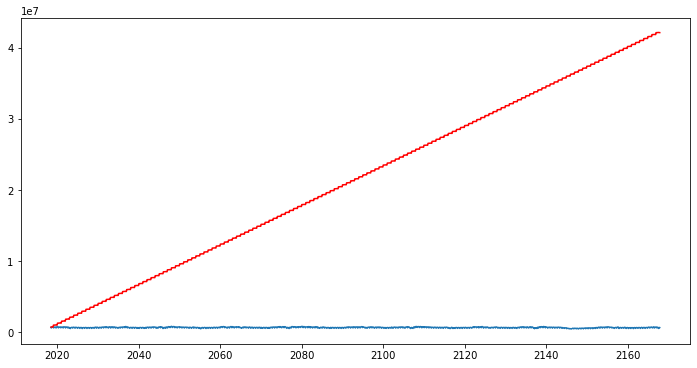

In [17]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

### Evaluación del modelo:

In [22]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse = round(rmse, 3)

In [23]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['demanda_energia']-predictions)
actual = test['demanda_energia']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [24]:
resultsDf = pd.DataFrame({'Method':['ARIMA'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,ARIMA,2.401414e+07,31.323


El error cuadrático medio (RMSE) es la desviación estándar de los residuos ( errores de predicción ). Los residuos son una medida de qué tan lejos están los puntos de datos de la línea de regresión; RMSE es una medida de la dispersión de estos residuos. En otras palabras, le dice qué tan concentrados están los datos alrededor de la línea de mejor ajuste.


El error de porcentaje absoluto medio (MAPE), también conocido como desviación de porcentaje absoluto medio (MAPD), es una medida de precisión de predicción de un método de pronóstico en estadística, por ejemplo, en estimación de tendencias, también utilizado como función de pérdida para problemas de regresión en Machine Learning.

### Referencias:

* https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def